# Tutorial 2: Bird Migration Analysis

This tutorial covers: 
1. TODO

This tutorial uses data published on Movebank, specifically Navigation experiments in lesser black-backed gulls (data from Wikelski et al. 2015)-gps.csv

In [1]:
%matplotlib inline

In [2]:
import urllib
import os
import pandas as pd
import movingpandas as mp
import contextily as ctx
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

## Loading the bird movement data 


In [3]:
# Loading geodata ...
t_start = datetime.now()
df = read_file('demo/demodata_gulls.gpkg')
wgs84 = df.crs
df['t'] = pd.to_datetime(df['timestamp'])
df = df.set_index('t')
print("Finished reading {} rows in {}".format(len(df),datetime.now() - t_start))

Finished reading 89867 rows in 0:00:05.994895


This is what the data looks like:

In [4]:
df.head()

,event-id,visible,timestamp,location-long,location-lat,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,geometry
t,,,,,,,,,,,
2009-05-27 14:00:00,1082620685,true,2009-05-27 14:00:00.000,24.58617,61.24783,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.58617 61.24783)
2009-05-27 20:00:00,1082620686,true,2009-05-27 20:00:00.000,24.58217,61.23267,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.58217 61.23267)
2009-05-28 05:00:00,1082620687,true,2009-05-28 05:00:00.000,24.53133,61.18833,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.53133 61.18833)
2009-05-28 08:00:00,1082620688,true,2009-05-28 08:00:00.000,24.58200,61.23283,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.582 61.23283)
2009-05-28 14:00:00,1082620689,true,2009-05-28 14:00:00.000,24.58250,61.23267,gps,Larus fuscus,91732,91732A,Navigation experiments in lesser black-backed ...,POINT (24.5825 61.23267)


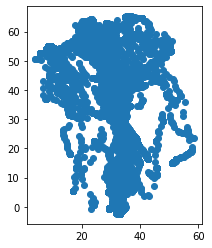

In [5]:
df.plot()

Let's see how many individuals we have in the dataset:

In [6]:
df['individual-local-identifier'].unique()

array(['91732A', '91733A', '91734A', '91735A', '91737A', '91738A',
       '91739A', '91740A', '91741A', '91742A', '91743A', '91744A',
       '91745A', '91746A', '91747A', '91748A', '91749A', '91750A',
       '91751A', '91752A', '91754A', '91755A', '91756A', '91758A',
       '91759A', '91761A', '91762A', '91763A', '91764A', '91765A',
       '91766A', '91767A', '91769A', '91771A', '91774A', '91775A',
       '91776A', '91777A', '91778A', '91779A', '91780A', '91781A',
       '91782A', '91783A', '91785A', '91786A', '91787A', '91788A',
       '91789A', '91794A', '91795A', '91797A', '91798A', '91799A',
       '91800A', '91802A', '91803A', '91807A', '91809A', '91810A',
       '91811A', '91812A', '91813A', '91814A', '91815A', '91816A',
       '91819A', '91821A', '91823A', '91824A', '91825A', '91826A',
       '91827A', '91828A', '91829A', '91830A', '91831A', '91832A',
       '91835A', '91836A', '91837A', '91838A', '91839A', '91843A',
       '91845A', '91846A', '91848A', '91849A', '91852A', '9185

The records per individual are not evenly distributed:

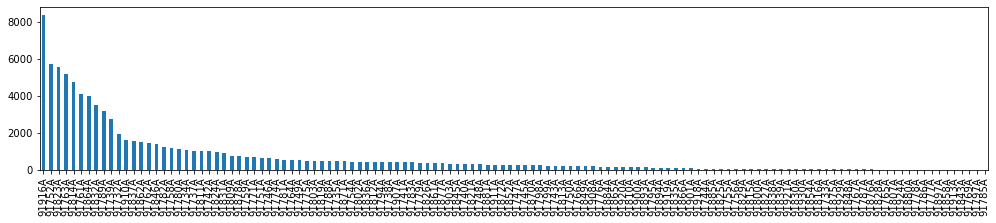

In [7]:
df['individual-local-identifier'].value_counts().plot(kind='bar', figsize=(17,3))

Finally, let's create trajectories:

In [8]:
MIN_LENGTH = 100 # meters

t_start = datetime.now()

trajectories = []
            
for key, values in df.groupby(['individual-local-identifier']):
    if len(values) < 2:
        continue
    trajectory = mp.Trajectory(key, values)
    if trajectory.get_length() < MIN_LENGTH:
        continue
    #print(trajectory)
    trajectories.append(trajectory)
    
print("Finished creating {} trajectories in {}".format(len(trajectories),datetime.now() - t_start))

Finished creating 125 trajectories in 0:00:18.178681


## Plotting trajectories



In [9]:
def plot_bird_trajectories(trajs):
    individual_to_color = {
        '91916A': 'blue'}
    default_color = 'lightgrey'

    ax = None
    for traj in trajs:
        individual = traj.df['individual-local-identifier'].iloc[0]

        try:
            individual_color = individual_to_color[individual]
        except KeyError:
            individual_color = default_color

        if ax is None:
            ax = traj.plot(linewidth=1, capstyle='round', column='individual-local-identifier', legend=True, figsize=(12,9), 
                           color=individual_color)
        else:
            traj.plot(ax=ax, linewidth=1, capstyle='round', column='individual-local-identifier', legend=True, figsize=(12,9), 
                      color=individual_color) 

In [10]:
%%time
#plot_bird_trajectories(trajectories)

Wall time: 0 ns


## Investigating individual trajectories

Let's pick out a specific bird:

In [11]:
def get_individual(trajs, id):
    for traj in trajs:
        if traj.id == id:
            return traj

my_traj = get_individual(trajectories, '91916A')
my_traj.df.head()

,event-id,visible,timestamp,location-long,location-lat,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,geometry
t,,,,,,,,,,,
2009-08-15 15:00:00,1082625177,true,2009-08-15 15:00:00.000,7.91500,54.18533,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (7.915 54.18533)
2009-08-15 21:00:00,1082625178,true,2009-08-15 21:00:00.000,7.91867,54.18467,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (7.91867 54.18467)
2009-08-16 06:00:00,1082625179,true,2009-08-16 06:00:00.000,8.06467,54.29600,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (8.06467 54.296)
2009-08-16 09:00:00,1082625180,true,2009-08-16 09:00:00.000,8.69100,54.53683,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (8.691000000000001 54.53683)
2009-08-16 15:00:00,1082625181,true,2009-08-16 15:00:00.000,9.44183,54.87233,gps,Larus fuscus,91916,91916A,Navigation experiments in lesser black-backed ...,POINT (9.44183 54.87233)


Conveniently, the plot function can automatically compute tavel speed and visualize it:

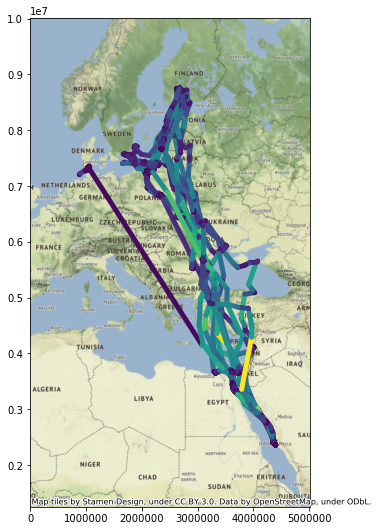

In [12]:
my_traj.plot(with_basemap=True, linewidth=5.0, capstyle='round', column='speed', figsize=(9,9), url=ctx.sources.ST_TERRAIN) 

In [13]:
trips_by_year = my_traj.split_by_date(mode='year')
for trip in trips_by_year:
    print(trip.id)

91916A_2009
91916A_2010
91916A_2011
91916A_2012
91916A_2013
91916A_2014
91916A_2015


In [14]:
one_year = get_individual(trips_by_year, '91916A_2010')
print(one_year)

Trajectory 91916A_2010 (2010-01-01 04:00:00 to 2010-12-31 19:00:00) | Size: 1381 | Length: 20853237.3m
Bounds: (17.88533, 21.02, 39.26733, 61.54733)
LINESTRING (39.16833 21.16633, 39.18983 21.1125, 39.1805 21.13, 39.18417 21.17583, 39.16717 21.15817


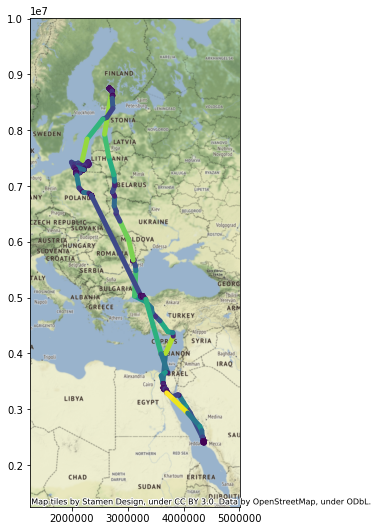

In [15]:
one_year.plot(with_basemap=True, linewidth=5.0, capstyle='round', column='speed', figsize=(9,9), url=ctx.sources.ST_TERRAIN)

Let's see where this individual was on specific days:

In [16]:
def plot_location_at_timestamp(traj, t):
    pos = traj.get_position_at(t)
    loc = GeoDataFrame(pd.DataFrame([{'geometry': pos, 'id': traj.id}]), crs=traj.crs)
    ax = traj.plot(with_basemap=True, linewidth=2.0, capstyle='round', color='black', figsize=(9,9), url=ctx.sources.ST_TONER_LITE)
    ax = loc.to_crs(epsg=3857).plot(ax=ax, markersize=150, figsize=(9,9))
    return ax

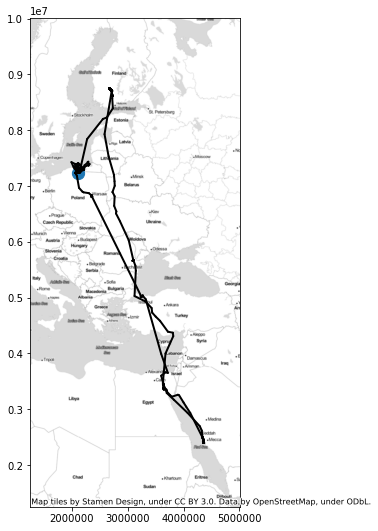

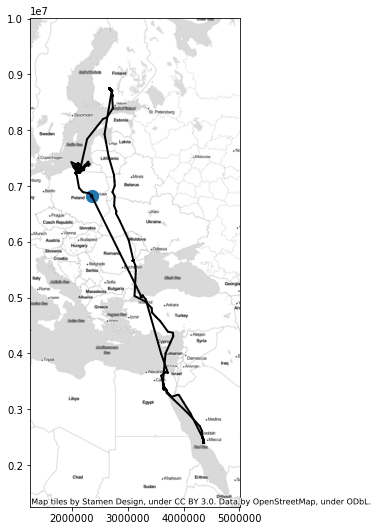

In [17]:
plot_location_at_timestamp(one_year, datetime(2010,9,1))
plot_location_at_timestamp(one_year, datetime(2010,10,1))

Similarly, it might also be of interest to see the different locations at a certain day each year:

In [20]:
def plot_location_at_day_of_year(traj, month, day):
    ts = [datetime(year, month, day) for year in traj.df.index.year.unique()]
    return plot_locations_at_timestamps(traj, ts)

def plot_locations_at_timestamps(traj, ts):  
    loc = get_locations_at_timestamps(traj, ts)
    ax = traj.plot(with_basemap=True, linewidth=1.0, capstyle='round', color='black', figsize=(9,9), url=ctx.sources.ST_TONER_LITE)
    ax = loc.to_crs(epsg=3857).plot(ax=ax, column='id', legend=True, markersize=150, figsize=(9,9))
    return ax    

def get_locations_at_timestamps(traj, ts):
    pos = []
    for t in ts:
        if t > traj.get_start_time() and t < traj.get_end_time():
            pos.append({'geometry': traj.get_position_at(t), 'id': str(t.date())})
    return GeoDataFrame(pd.DataFrame(pos), crs=traj.crs)

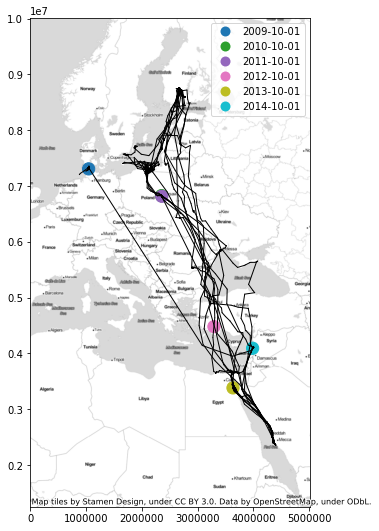

In [21]:
plot_location_at_day_of_year(my_traj, month=10, day=1)